### Dependencies

In [105]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline

### Dataset

In [7]:
df = pd.read_csv('https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv')
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


### Dataset Preparation

In [16]:
df.columns = df.columns.str.lower().str.replace(' ','_')

In [18]:
df.dtypes

jamb_score                        int64
study_hours_per_week              int64
attendance_rate                   int64
teacher_quality                   int64
distance_to_school              float64
school_type                      object
school_location                  object
extra_tutorials                  object
access_to_learning_materials     object
parent_involvement               object
it_knowledge                     object
student_id                        int64
age                               int64
gender                           object
socioeconomic_status             object
parent_education_level           object
assignments_completed             int64
dtype: object

In [20]:
for c in df.dtypes[df.dtypes == 'object'].index:
    df[c] = df[c].str.lower().str.replace(' ','_')

In [22]:
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,student_id,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,public,urban,yes,yes,high,medium,1,17,male,low,tertiary,2
1,207,14,88,4,2.7,public,rural,no,yes,high,high,2,15,male,high,NaN,1
2,182,29,87,2,9.6,public,rural,yes,yes,high,medium,3,20,female,high,tertiary,2
3,210,29,99,2,2.6,public,urban,no,yes,medium,high,4,22,female,medium,tertiary,1
4,199,12,98,3,8.8,public,urban,no,yes,medium,medium,5,22,female,medium,tertiary,1


In [24]:
df.describe()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,student_id,age,assignments_completed
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,174.074600,19.521200,84.235200,2.521400,10.005460,2500.500000,18.445800,1.804600
std,47.616477,9.634569,9.485688,0.985564,4.820221,1443.520003,2.301504,0.992076
min,100.000000,0.000000,50.000000,1.000000,0.000000,1.000000,15.000000,1.000000
25%,135.000000,13.000000,78.000000,2.000000,6.600000,1250.750000,16.000000,1.000000
50%,170.000000,19.000000,84.000000,2.000000,10.000000,2500.500000,18.000000,1.000000
75%,209.000000,26.000000,91.000000,3.000000,13.400000,3750.250000,20.000000,2.000000
max,367.000000,40.000000,100.000000,5.000000,20.000000,5000.000000,22.000000,5.000000


In [26]:
df.isna().sum()

jamb_score                        0
study_hours_per_week              0
attendance_rate                   0
teacher_quality                   0
distance_to_school                0
school_type                       0
school_location                   0
extra_tutorials                   0
access_to_learning_materials      0
parent_involvement                0
it_knowledge                      0
student_id                        0
age                               0
gender                            0
socioeconomic_status              0
parent_education_level          891
assignments_completed             0
dtype: int64

- Drop the `student_id` column
- Fill in missing values with zeros
- Do `train/validation/test` split with `60%/20%/20%` distribution.
- 
Use the` train_test_spli`t function and set the` random_stat`e parameter to 1
- 
Us`e DictVectorizer(sparse=Tru`) to turn the dataframes into matrices.

In [29]:
del df['student_id']

In [31]:
df = df.fillna(0)

In [33]:
# Split dataset
df_train_full,df_test = train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val = train_test_split(df_train_full,test_size=0.25,random_state=1)

In [35]:
len(df),len(df_train_full),len(df_train),len(df_val),len(df_test)

(5000, 4000, 3000, 1000, 1000)

In [37]:
# Turn Df into Matrices
y_train_full = df_train_full['jamb_score'].values
y_train = df_train['jamb_score'].values
y_val = df_val['jamb_score'].values
y_test = df_test['jamb_score'].values

In [39]:
del df_train_full['jamb_score']
del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

In [41]:
# Dictionaries
dict_train_full = df_train_full.to_dict(orient='records')
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')
dict_test = df_test.to_dict(orient='records')

In [43]:
dv = DictVectorizer(sparse=True)
X_train_full = dv.fit_transform(dict_train_full)
X_train = dv.fit_transform(dict_train)
X_val = dv.fit_transform(dict_val)
X_test = dv.fit_transform(dict_test)

## Question 1

Let's train a decision tree regressor to predict the `jamb_score` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `study_hours_per_week`
* `attendance_rate`
* `teacher_quality`
* `distance_to_school`

In [45]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=1)

In [47]:
print(export_text(dt,feature_names=dv.get_feature_names_out()))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



## Question 2

Train a random forest regressor with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on the validation data?

* 22.13
* 42.13
* 62.13
* 82.12

In [61]:
rf = RandomForestRegressor(n_estimators=10,random_state=1)
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [63]:
y_val_pred = rf.predict(X_val)
y_val_pred
root_mean_squared_error(y_val,y_val_pred)

42.13724207871227

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for calculating the answer.

- 10
- 25
- 80
- 200

In [68]:
scores = []
for n in np.arange(10,200,10):
    rf = RandomForestRegressor(n_estimators=n,random_state=1)
    rf.fit(X_train,y_train)
    y_val_pred = rf.predict(X_val)
    rmse = root_mean_squared_error(y_val,y_val_pred)
    scores.append((n,rmse.round(3)))

In [74]:
df_scores = pd.DataFrame(scores,columns=['n_estimator','rmse'])
df_scores

,n_estimator,rmse
0,10,42.137
1,20,41.461
2,30,41.106
3,40,40.917
4,50,40.852
5,60,40.784
6,70,40.677
7,80,40.539
8,90,40.504
9,100,40.517


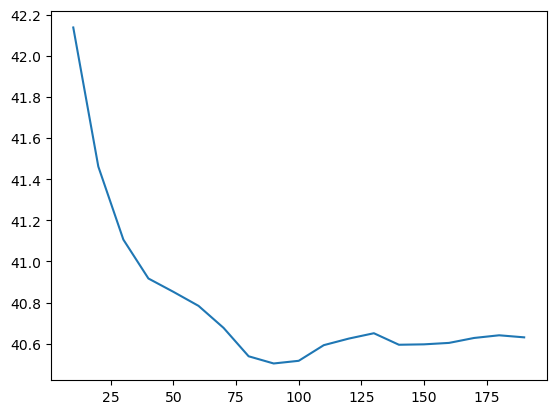

In [78]:
plt.plot(df_scores.n_estimator,df_scores.rmse)

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25


In [80]:
scores = []

for max_depth in [10,15,20,25]:
    for n in np.arange(10,200,10):
        rf = RandomForestRegressor(n_estimators=n,random_state=1,max_depth=max_depth)
        rf.fit(X_train,y_train)
        y_val_pred = rf.predict(X_val)
        rmse = root_mean_squared_error(y_val,y_val_pred)
        scores.append((max_depth,n,rmse.round(3)))

In [81]:
df_scores = pd.DataFrame(scores,columns=['max_depth','n_estimator','rmse'])
df_scores

,max_depth,n_estimator,rmse
0,10,10,41.258
1,10,20,40.881
2,10,30,40.625
3,10,40,40.270
4,10,50,40.317
...,...,...,...
71,25,150,40.593
72,25,160,40.600
73,25,170,40.624
74,25,180,40.639


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


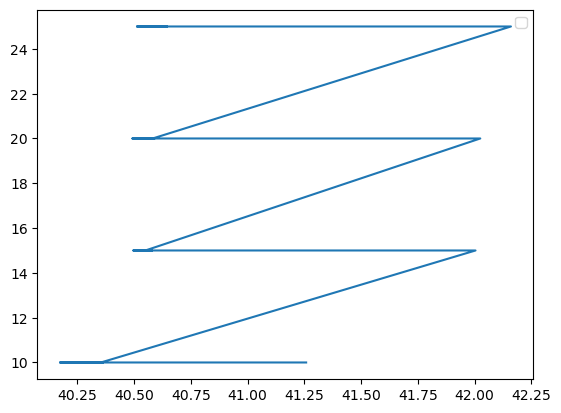

In [87]:
plt.plot(df_scores.rmse,df_scores.max_depth)
plt.legend()

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `study_hours_per_week`
* `attendance_rate`
* `distance_to_school`
* `teacher_quality

In [95]:
rf = RandomForestRegressor(n_estimators=10,random_state=1,max_depth=20,n_jobs=-1)
rf.fit(X_train,y_train)
feature_importances = rf.feature_importances_
feature_names = dv.get_feature_names_out()
features = zip(feature_names,feature_importances)
features

In [97]:
df_features = pd.DataFrame(features, columns=['feature_name','importance'])
df_features

,feature_name,importance
0,access_to_learning_materials=no,0.012325
1,access_to_learning_materials=yes,0.010262
2,age,0.069311
3,assignments_completed,0.031517
4,attendance_rate,0.149729
5,distance_to_school,0.136486
6,extra_tutorials=no,0.013459
7,extra_tutorials=yes,0.009131
8,gender=female,0.009289
9,gender=male,0.010383


In [101]:
df_features.sort_values('importance',ascending=False).head()

,feature_name,importance
27,study_hours_per_week,0.248354
4,attendance_rate,0.149729
5,distance_to_school,0.136486
28,teacher_quality,0.082682
2,age,0.069311


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2024/homework/hw06
* If your answer doesn't match options exactly, select the closest one

In [115]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    'eval_metric': 'rmse',
    
    'seed': 1,
    'verbosity': 1,
}

In [ ]:
scores = {}

In [117]:
watch_list = ((dtrain,'train'),(dval,'val'))

In [133]:
dtrain = xgb.DMatrix(X_train,label=y_train,feature_names=list(dv.get_feature_names_out()))
dval = xgb.DMatrix(X_val,label=y_val,feature_names=list(dv.get_feature_names_out()))
dtest = xgb.DMatrix(X_test,label=y_test,feature_names=list(dv.get_feature_names_out()))

TypeError: Expecting a sequence of strings for feature names, got: <class 'numpy.ndarray'>

In [123]:
%%capture model_output
model = xgb.train(xgb_params,dtrain,num_boost_round=100,evals=watch_list)

In [131]:
print(model_output)

[0]	train-rmse:42.69384	val-rmse:44.89114
[1]	train-rmse:39.83326	val-rmse:43.07010
[2]	train-rmse:37.94542	val-rmse:42.00332
[3]	train-rmse:36.56125	val-rmse:41.46452
[4]	train-rmse:35.44252	val-rmse:40.88896
[5]	train-rmse:34.57756	val-rmse:40.69096
[6]	train-rmse:33.84230	val-rmse:40.59315
[7]	train-rmse:33.25929	val-rmse:40.47993
[8]	train-rmse:32.79415	val-rmse:40.45326
[9]	train-rmse:32.16019	val-rmse:40.43929
[10]	train-rmse:31.63404	val-rmse:40.48319
[11]	train-rmse:31.17673	val-rmse:40.68201
[12]	train-rmse:30.87313	val-rmse:40.63522
[13]	train-rmse:30.30310	val-rmse:40.70983
[14]	train-rmse:30.00098	val-rmse:40.78133
[15]	train-rmse:29.41497	val-rmse:40.86107
[16]	train-rmse:29.25816	val-rmse:40.96580
[17]	train-rmse:28.59378	val-rmse:41.12190
[18]	train-rmse:28.27990	val-rmse:41.14360
[19]	train-rmse:27.94572	val-rmse:41.22835
[20]	train-rmse:27.49658	val-rmse:41.27921
[21]	train-rmse:27.25449	val-rmse:41.32427
[22]	train-rmse:27.06652	val-rmse:41.41887
[23]	train-rmse:26.78